In [1]:
pip install ortools


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Users\himan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip




# new empliment


from ortools.linear_solver import pywraplp

# Create the solver
solver = pywraplp.Solver.CreateSolver('GLOP')

# Define variables
n = 5
Qprod = [solver.NumVar(0, solver.infinity(), f'Qprod_{i}') for i in range(n)]
Tbuffer = [solver.NumVar(0, solver.infinity(), f'Tbuffer_{i}') for i in range(n)]
r = [10, 20, 30, 40, 50]  # Example values
S = [[1, 2, 3, 4, 5] for _ in range(n)]  # Example values
C = 10  # Example value

# Add constraints
for i in range(n):
    solver.Add(-sum(S[i][j] / C * Qprod[j] for j in range(n)) + Tbuffer[i] == r[i])

# Add objective (example: minimize sum of Qprod)
solver.Minimize(sum(Qprod[i] for i in range(n)))

# Solve the problem
status = solver.Solve()

# Check the solution
if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    for i in range(n):
        print(f'Qprod[{i}] = {Qprod[i].solution_value()}')
else:
    print('The problem does not have an optimal solution.')

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tout       8760 non-null   float64
 1   Qhouse     8760 non-null   float64
 2   Price el.  8760 non-null   float64
dtypes: float64(3)
memory usage: 273.8+ KB
Runtime linear solver: 265.13 s
Optimal total cost (with temperature costs): 1798.33 €
Costs excluding temperature costs: 705.31 €
Optimal Qprod: [1.113220055250278, 0.053745696933471414, 0.15876485730050938, 0.0, 0.0023599006514034696, 1.0553918214554627, 4.39105406462584, 8.31594686444301, 2.7522985387670165, 4.939440918853127, 0.5674309991579427, 3.0207310634886855, 1.6019468335765645, 3.224271331450338, 0.8584359692096322, 5.648094950404635, 0.5348468915682544, 6.3937669581996035, 1.0533911735227373, 4.597224430492639, 1.7229543560261724, 3.0242148382973437, 3.288921247858922, 1.3143469904373233, 0.1219005337520

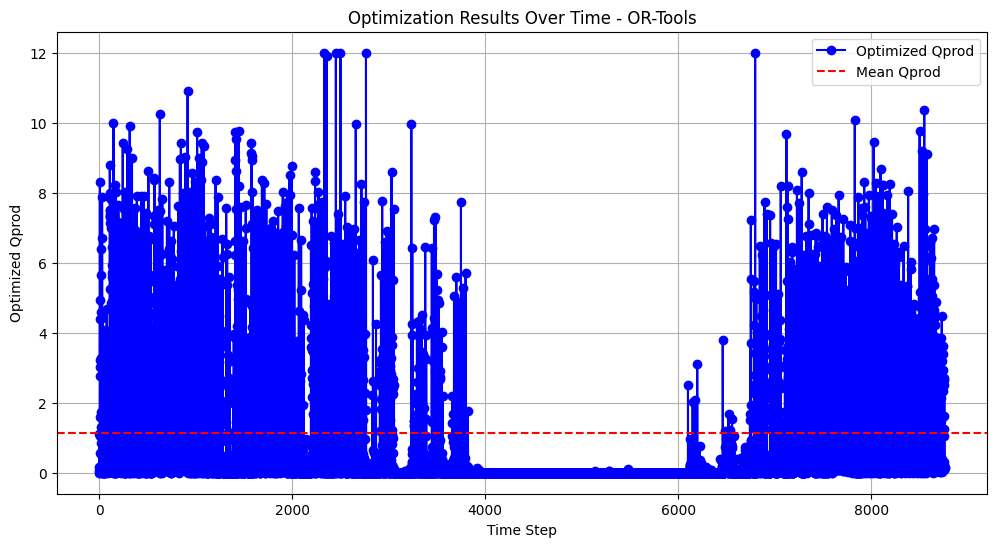

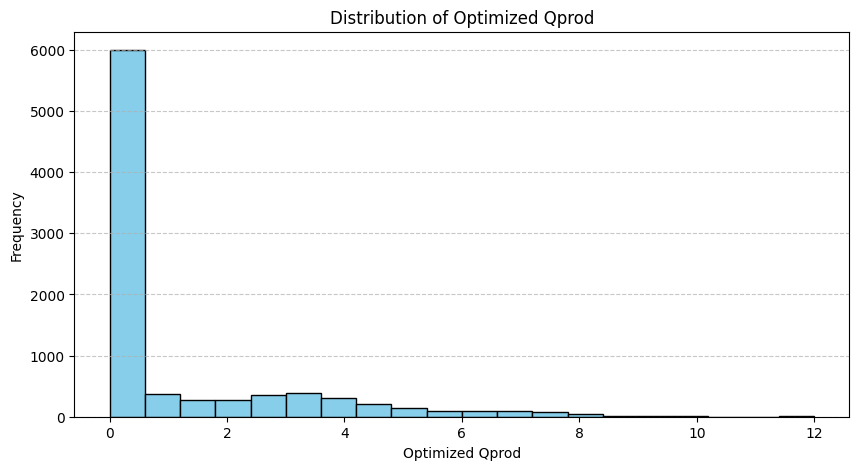

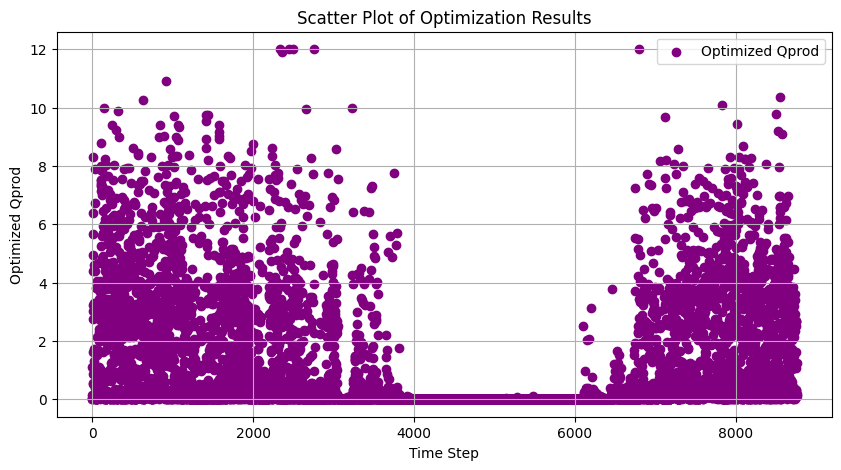

In [ ]:
from ortools.linear_solver import pywraplp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from BasicDefinitions import *

# Load data
df = pd.read_csv("D:/thesis/LinearExample/YearHourly.csv", header=None, index_col=0)
df.columns = ["Tout", "Qhouse", "Price el."]
df.index.name = "Time"
df.info()

Tout = df["Tout"].to_numpy()
Tflow = fTflow(Tout)
Qhouse = df["Qhouse"].to_numpy()
p = df["Price el."].to_numpy()
n = p.size

# Define matrices for constraints
E = np.eye(n)
S = np.tril(np.ones_like(E), 0)  # Lower triangular matrix
C_scalar = float(4.2 * 500 / 3600)  # Convert to scalar
Tinit = 30
M = S / C_scalar
r = Tinit - np.matmul(S, Qhouse) / C_scalar

# Create solver
solver = pywraplp.Solver.CreateSolver('GLOP')
if not solver:
    raise Exception("GLOP solver is not available.")

# Define variables
Qprod = [solver.NumVar(0, Pth, f'Qprod_{i}') for i in range(n)]
Tbuffer = [solver.NumVar(Tflow[i], Tmax, f'Tbuffer_{i}') for i in range(n)]

# Cost coefficients
a = 3
cel = p / CoP(Tout, Tflow)
cte = p / CoP(Tout, Tflow + 1) - p / CoP(Tout, Tflow)

# Objective function
objective = solver.Objective()
for i in range(n):
    objective.SetCoefficient(Qprod[i], cel[i])
    objective.SetCoefficient(Tbuffer[i], a * cte[i])
objective.SetMinimization()

# Constraints for buffer temperature dynamics
for i in range(n):
    buffer_expr = sum([-S[i, j] / C_scalar * Qprod[j] for j in range(n)])
    solver.Add(buffer_expr + Tbuffer[i] == r[i])

# Ensure total produced heat meets the demand
solver.Add(sum(Qprod) >= Qhouse.sum())

# Solve the problem
start = time.time()
status = solver.Solve()
end = time.time()

# Output results
print(f"Runtime linear solver: {end - start:.2f} s")

if status == pywraplp.Solver.OPTIMAL:
    print(f"Optimal total cost (with temperature costs): {solver.Objective().Value():.2f} €")
    Qprod_opt = [Qprod[i].solution_value() for i in range(n)]
    Tbuffer_opt = [Tbuffer[i].solution_value() for i in range(n)]
    costs_excluding_temperature = sum(cel[i] * Qprod_opt[i] for i in range(n))
    print(f"Costs excluding temperature costs: {costs_excluding_temperature:.2f} €")
    print("Optimal Qprod:", Qprod_opt)
    print("Optimal Tbuffer:", Tbuffer_opt)
else:
    print("The problem does not have an optimal solution.")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(n), Qprod_opt, marker='o', linestyle='-', color='b', label='Optimized Qprod')
plt.axhline(y=np.mean(Qprod_opt), color='r', linestyle='--', label='Mean Qprod')
plt.xlabel("Time Step")
plt.ylabel("Optimized Qprod")
plt.title("Optimization Results Over Time - OR-Tools")
plt.legend()
plt.grid()
plt.show()

# Histogram of optimized values
plt.figure(figsize=(10, 5))
plt.hist(Qprod_opt, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Optimized Qprod")
plt.ylabel("Frequency")
plt.title("Distribution of Optimized Qprod")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Scatter plot to observe any patterns
plt.figure(figsize=(10, 5))
plt.scatter(range(n), Qprod_opt, color='purple', label='Optimized Qprod')
plt.xlabel("Time Step")
plt.ylabel("Optimized Qprod")
plt.title("Scatter Plot of Optimization Results")
plt.legend()
plt.grid()
plt.show()
